## Pathological Myopia Detection Using Fundus Images

In [ ]:
pip install keras

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib as plt
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.models import model_from_json
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/sabahat/.local/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Image Processing Libraries
from tqdm import tqdm  # to show processing bar
from skimage.io import imread, imshow
from skimage.transform import resize

In [3]:
''' Standard Size of Images '''
img_width = 128 
img_hight = 128
img_channels = 3
# adjust randome seed size
seed = 42
np.random.seed = seed

##  Data Preprocessing

Resizing Training Images

In [4]:
'''  
Data Preprocessing
''' 
train_path = 'PALM-Training400/'
test_path = 'Validation/'
train_ids = next(os.walk(train_path))[2]#next return a tuple(all folders at 1 position
# test_ids = next(os.walk(test_path))[2]
# print(len(train_ids))
# print(len(test_ids))
X_train = np.zeros((len(train_ids),img_hight, img_width, img_channels), dtype=np.uint8)
# X_train.shape
Y_train = np.zeros((len(train_ids),img_hight, img_width, 1), dtype=np.bool) # for Masks
# Y_train.shape
#
""" Resizing Training Images  """
#
masks_path = next(os.walk('masks/'))[2]
# print(masks_path)
training_ids = sorted(train_ids)
masks_ids = sorted(masks_path)
indx = 0
print('Resizing Training Images and Masks')
for img_id in tqdm(training_ids):
    image = imread(train_path+img_id)[:,:,:img_channels]
    image = resize(image, (img_hight, img_width), mode='constant', preserve_range= True)
    X_train[indx] = image # fill empty X_train with values from images
    mask = np.zeros((img_hight, img_width, 1), dtype=np.bool)
#     for mask_file in next(os.walk(path+'/masks/'))[2]:
    test_mask = imread('masks/'+masks_ids[indx])
    test_mask = np.expand_dims(resize(test_mask,(img_hight, img_width), mode='constant', preserve_range=True), axis=-1)#
#     mask = np.maximum(mask, test_mask)
    Y_train[indx] = test_mask
    indx += 1 



  0%|          | 0/400 [00:00<?, ?it/s]

Resizing Training Images and Masks


100%|██████████| 400/400 [18:29<00:00,  2.77s/it]


In [5]:
test_path = next(os.walk('Validation/'))[2]
test_ids = sorted(test_path)
# print(test_ids)

Resizing Test Images

In [6]:
X_test = np.zeros((len(test_ids),img_hight, img_width, img_channels), dtype=np.uint8)
# X_test.shape
sizes_test = []
print('Resizing Test Images...')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path =  'Validation/' + id_
    image = imread(path)[:,:,:img_channels]
    sizes_test.append([image.shape[0], image.shape[1]])
    image1 = resize(image, (img_hight, img_width), mode='constant', preserve_range=True)
    X_test[n] = image1
print('Resizing Done!!!')

  0%|          | 0/400 [00:00<?, ?it/s]

Resizing Test Images...


100%|██████████| 400/400 [08:53<00:00,  1.33s/it]

Resizing Done!!!


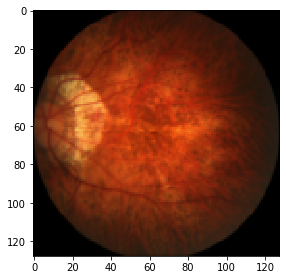

In [7]:
imshow(X_test[15]) # showing image
plt.show()

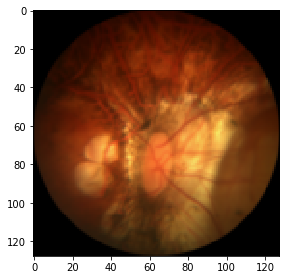

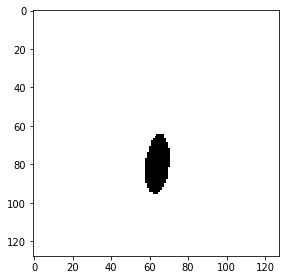

In [8]:
# Ploting Some Random Images
# image_x = 658
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x]) # showing image
plt.show()
imshow(np.squeeze(Y_train[image_x])) # show coresponding mask
plt.show()


In [9]:
print(train_ids[image_x])

P0098.jpg


Build the Model (Creating Neural Network)

In [10]:
# Build the Model
inputs = tf.keras.layers.Input((img_width, img_hight, img_channels)) # Input Layer
float_Values = tf.keras.layers.Lambda(lambda x: x / 255)(inputs) # converting each value into flot for Neural Network
# Contraction path (going down)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(float_Values)
c1 = tf.keras.layers.Dropout(0.1)(c1) # dropout of 10%
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1) # creating new Layer
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)  # MaxPolling layer

c2 = tf.keras.layers.Conv2D(32,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout((0.2))(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
p5 = tf.keras.layers.MaxPooling2D((2,2))(c5)

Up Scallig

In [11]:
#Expensive Path (Up Scalling)
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)##
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)##
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (2,2), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (2,2), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
# Output layer
outputs = tf.keras.layers.Conv2D(1,(1,1), activation='sigmoid')(c9)

Compiling Model

In [12]:
# Compiling Model
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy')#, matrices=['accuracy'])  #optimize contais  Back propagation

Model Summary

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

ModelCheckpoints and Callbacks

In [14]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# ModelCheckpoints
checkPointer = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    checkPointer
]
''' Following Command is used to Open Tensorboard into Browser'''
"""  
tensorboard --logdir=logs/ --host localhost --port 8088
"""


'  \ntensorboard --logdir=logs/ --host localhost --port 8088\n'

In [15]:
# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))


Fitting the Model 

In [16]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)#

Train on 360 samples, validate on 40 samples
Epoch 1/25
352/360 [============================>.] - ETA: 1s - loss: 0.4071
Epoch 00001: val_loss improved from inf to 0.09184, saving model to training_2/cp-0001.ckpt
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: training_2/cp-0001.ckpt/assets
360/360 [==============================] - 55s 153ms/sample - loss: 0.4000 - val_loss: 0.0918
Epoch 2/25
352/360 [============================>.] - ETA: 0s - loss: 0.0711
Epoch 00002: val_loss improved from 0.09184 to 0.05642, saving model to training_2/cp-0002.ckpt
INFO:tensorflow:Assets written to: training_2/cp-0002.ckpt/assets
360/360 [==============================] - 49s 136ms/sample - loss: 0.0708 - val_loss: 0.0564
Epoch 3/25
352/360 [============================>.] - ETA: 0s - loss: 0.0517
Epoch 00003: val_loss improved from 0.05642 to 0.04751, saving model to training_2/cp-0003.ckpt
INFO:tensorflow:Assets written to: trai

In [17]:
# Save the entire model as a SavedModel.
#!mkdir -p saved_model
model.save('saved_model/my_model') 

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [18]:
new_model = tf.keras.models.load_model('saved_model/my_model')

In [19]:
# Check its architecture
new_model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

#### Validation (Testing)

In [28]:
idx = random.randint(0, len(X_train))

# preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
# preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
# preds_test = model.predict(X_test, verbose=1)
predected_valid = new_model.predict(X_test[:int(X_test.shape[0]*0.9)], verbose=1)
preds_valid_t = (predected_valid > 0.5).astype(np.uint8)
# preds_val_t = (preds_val > 0.5).astype(np.uint8)
# preds_test_t = (preds_test > 0.5).astype(np.uint8)


360/360 [==============================] - 9s 25ms/sample


Actual Fundus Image:


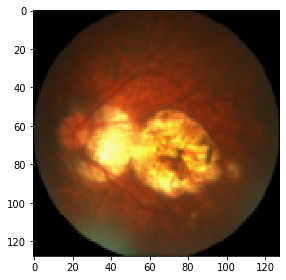

Predicted Optic Disk:


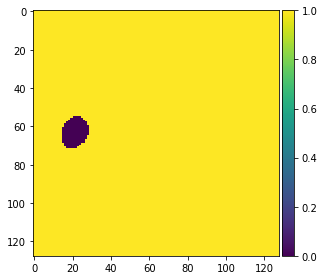

In [32]:
# perform a sanity check on some random training samples
#ix = random.randint(0, len(preds_valid_t))
ix=101
print('Actual Fundus Image:')
imshow(X_test[ix])
plt.show()
print('Predicted Optic Disk:')
imshow(np.squeeze(preds_valid_t[ix]))
plt.show()

## Extracting PPA

In [ ]:
import cv2
import matplotlib as plt
import os

In [ ]:
train_path = next(os.walk('fundus/'))[2]
train_ids = sorted(train_path)
# train_ids = train_ids[317:]
# train_ids = ['P0166.jpg','P0200.jpg','P0130.jpg']
print(train_ids)

In [ ]:
path = 'ODRadius'
for filename in train_ids:
    mId = filename.split('.')[0]
    img = cv2.imread('masks/'+mId+'.bmp',0)
    imm=cv2.imread('masks/'+mId+'.bmp',0)
    iml=cv2.imread('masks/'+mId+'.bmp',0)
#     img = cv2.resize(img1, (400,400))
    ret,thresh = cv2.threshold(img,120,255,0)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)
    cnt = contours[0]
    cnt = contours[0]
    M = cv2.moments(cnt)
    (x,y),radius = cv2.minEnclosingCircle(cnt)
    center = (int(x),int(y))
    radius = int(radius)
    radius += 40
    for i in range(1,110):
        img = cv2.circle(img,center,radius-i,(0,255,0),85)
    # print(radius)
    img2 = cv2.imread('PALM-Training400/'+filename,0)
    fimg = cv2.bitwise_or(img2,img)
    fimg=cv2.bitwise_or(fimg,iml)
    cv2.imwrite(os.path.join(path ,mId+'.jpg'), fimg)
# cv2.imshow('detected circles',img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()